# This notebook will build the model for predicting the price of properties. 
## 1. First basic model based on multiple linear regression.
### 1. import libraries


In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import re
import sys
sys.path.insert(0, '../')
import numpy as np
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from src.clean_data import run_cleanup
from src.clean_data import split_df_on_type
from src.linear_model import model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error

### 2. Read the csv-file and put it into a pandas DataFrame

print(df_house.head())
print(df_apt.head())

In [96]:
file_path = '../Data/house_details_v1.csv'
df = pd.read_csv(file_path, index_col='id', skip_blank_lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19963 entries, 10683823 to 10664014
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Street             19963 non-null  object 
 1   Housenumber        19963 non-null  object 
 2   Box                19963 non-null  object 
 3   Floor              19963 non-null  float64
 4   City               19963 non-null  object 
 5   Postalcode         19963 non-null  object 
 6   Type               19963 non-null  object 
 7   Subtype            19963 non-null  object 
 8   Location area      19963 non-null  object 
 9   Region             19963 non-null  object 
 10  District           19963 non-null  object 
 11  Province           19963 non-null  object 
 12  Price              19963 non-null  float64
 13  Type of sale       19963 non-null  object 
 14  Construction year  19963 non-null  float64
 15  Total surface      19963 non-null  float64
 16  Habitable surface

### 3. Clean data via clean_data.py:

In [97]:
drop_columns=[
            'Street', 'Housenumber', 'Box', 'City', 'Subtype', 'Location area', 'Region', 
            'District', 'Province', 'Type of sale', 'Garden', 'Kitchen type', 'EPC score', 'Latitude',
            'Longitude', 'Property url'
            ]
df, df_house, df_apt = run_cleanup(df)

Step 1 trans_to_bool:
Df rows after step 1: 19963
Step 2 convert_to_num:
Df rows after step 2: 19963
Step 3 clean_postalcodes:
Df rows after step 3: 19884
Step 4 drop_zero_rows:
Df rows after step 4: 17840
Step 5 remove_duplicates:
Amount of duplicates: 4555
Amount of rows after step 5: 15500
Step 6 remove_outliers:
Amount of rows after step 6: 15384
Step 7 drop_outside_belgium:
7894
4500
2952
38
total amount = 15384
Amount of rows after step 7: 15346
Step 8 ordinal_encode_condition_column:
Amount of rows after step 8: 15346
Step 9 check_nan:
Index([], dtype='object')
Total NaN values in the DataFrame: 0
Step 10 split_df_on_type:
Amount of rows after step 10: 15346
Amount of rows in df_house: 9100
Amount of rows in df_apt: 6246


In [98]:
df_apt= df_apt.drop(columns= [
            'Type', 'Garden surface', 'SwimmingPool', 'Condition', 'Postalcode', 'Street', 'Housenumber',
            'Box', 'City', 'Subtype', 'Location area', 'Region', 'District', 'Province', 'Type of sale',
            'Garden', 'Kitchen type', 'EPC score', 'Latitude', 'Longitude', 'Property url'
            ])
df_house= df_house.drop(columns= [
            'Type', 'Floor', 'Condition', 'Postalcode', 'Floor', 'Street', 'Housenumber', 'Box', 'City', 'Subtype',
            'Location area', 'Region', 'District', 'Province', 'Type of sale', 'Garden', 'Kitchen type',
            'EPC score', 'Latitude','Longitude', 'Property url'
            ])
df= df.drop(columns=[
            'Type', 'Postalcode', 'Condition', 'Street', 'Housenumber', 'Box', 'City', 'Subtype', 'Location area',
            'Region', 'District', 'Province', 'Type of sale', 'Garden', 'Kitchen type', 'EPC score', 'Latitude',
            'Longitude', 'Property url'
            ])

In [99]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9100 entries, 10689265 to 10664014
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              9100 non-null   float64
 1   Construction year  9100 non-null   float64
 2   Total surface      9100 non-null   float64
 3   Habitable surface  9100 non-null   float64
 4   Bedroom count      9100 non-null   float64
 5   Furnished          9100 non-null   bool   
 6   Fireplace          9100 non-null   bool   
 7   Terrace            9100 non-null   bool   
 8   Terrace surface    9100 non-null   float64
 9   Garden surface     9100 non-null   float64
 10  Facades            9100 non-null   float64
 11  SwimmingPool       9100 non-null   bool   
 12  Kitchen equipped   9100 non-null   int64  
 13  Condition_encoded  9100 non-null   int64  
dtypes: bool(4), float64(8), int64(2)
memory usage: 817.6 KB


In [100]:
df_apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6246 entries, 10683823 to 10664031
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Floor              6246 non-null   float64
 1   Price              6246 non-null   float64
 2   Construction year  6246 non-null   float64
 3   Total surface      6246 non-null   float64
 4   Habitable surface  6246 non-null   float64
 5   Bedroom count      6246 non-null   float64
 6   Furnished          6246 non-null   bool   
 7   Fireplace          6246 non-null   bool   
 8   Terrace            6246 non-null   bool   
 9   Terrace surface    6246 non-null   float64
 10  Facades            6246 non-null   float64
 11  Kitchen equipped   6246 non-null   int64  
 12  Condition_encoded  6246 non-null   int64  
dtypes: bool(3), float64(8), int64(2)
memory usage: 555.1 KB


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15346 entries, 10683823 to 10664014
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Floor              15346 non-null  float64
 1   Price              15346 non-null  float64
 2   Construction year  15346 non-null  float64
 3   Total surface      15346 non-null  float64
 4   Habitable surface  15346 non-null  float64
 5   Bedroom count      15346 non-null  float64
 6   Furnished          15346 non-null  bool   
 7   Fireplace          15346 non-null  bool   
 8   Terrace            15346 non-null  bool   
 9   Terrace surface    15346 non-null  float64
 10  Garden surface     15346 non-null  float64
 11  Facades            15346 non-null  float64
 12  SwimmingPool       15346 non-null  bool   
 13  Kitchen equipped   15346 non-null  int64  
 14  Condition_encoded  15346 non-null  int64  
dtypes: bool(4), float64(9), int64(2)
memory usage: 1.5 MB


In [56]:
nan_values = df.isna().any()

# Print the columns with NaN values, if any
print(nan_values[nan_values].index)
total_nan_values = df.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {total_nan_values}")


Index([], dtype='object')
Total NaN values in the DataFrame: 0


In [57]:
# Check for NaN values in the DataFrame
nan_counts = df.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

Floor                0
Postalcode           0
Type                 0
Price                0
Construction year    0
Total surface        0
Habitable surface    0
Bedroom count        0
Furnished            0
Fireplace            0
Terrace              0
Terrace surface      0
Garden surface       0
Facades              0
SwimmingPool         0
Condition            0
Kitchen equipped     0
Condition_encoded    0
dtype: int64


#### 3.1 Check for features with too strong correlation (= more than 0.70)

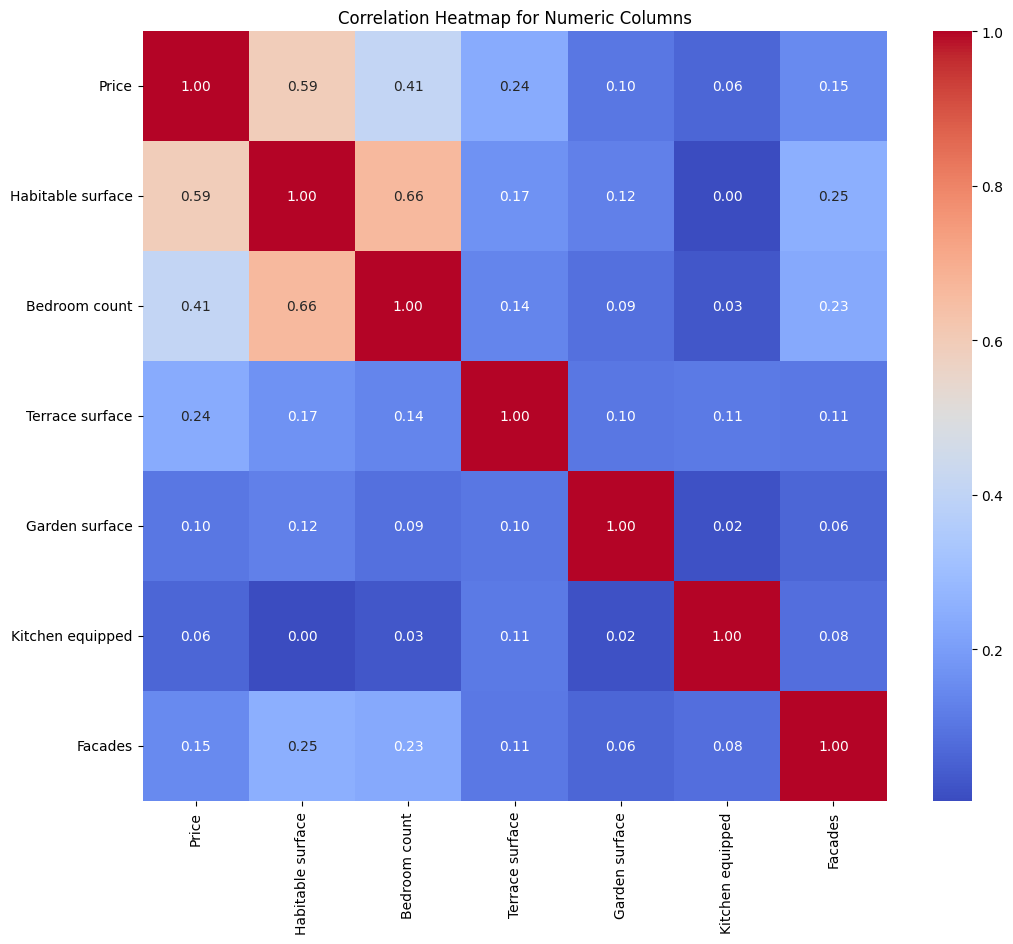

In [102]:
house_columns = ['Price', 'Habitable surface', 'Bedroom count', 'Terrace surface', 'Garden surface', 'Kitchen equipped', 'Facades']
#numeric_df = df.select_dtypes(include=[float, int])
numeric_df = df[house_columns]
# Compute the correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Add a title to the heatmap
plt.title("Correlation Heatmap for Numeric Columns")

# Show the plot
plt.show()

### 4. First pipeline on the DataFrame:

Model running for house listings only

In [106]:
X = df_house.drop(columns='Price')
y = df_house.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)

0.49387886190582664
87721241226.85776


Model for apartment listings only

In [107]:
X = df_apt.drop(columns='Price')
y = df_apt.Price.to_numpy()
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)


0.40753016949303855
88666619534.03943


### 5. Try a non-linear model: XGboost

In [108]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

X = df_apt.drop(columns='Price')
y = df_apt.Price.to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize and train the XGBoost regression model
xgb_model = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
xgb_model.fit(X_train, y_train)

# Evaluate the model on training and testing data
print("Training R-squared score:", xgb_model.score(X_train, y_train))
print("Testing R-squared score:", xgb_model.score(X_test, y_test))

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print("Mean Squared Error:", mse)

# Perform cross-validation and compute mean and standard deviation of R-squared scores
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)

fig = go.Figure()

# Add actual prices and predicted prices as scatter plot traces
fig.add_trace(go.Scattergl(x=y_test.flatten(),
                           y=y_pred,
                           mode='markers',
                           marker=dict(color='blue', size=8),
                           name='Predicted vs. Actual Prices',
                           text=[f'Data Point Index: {i}' for i in np.arange(len(y_test))],
                           hoverinfo='text+x+y'))

# Add a 1:1 line (y=x) to indicate perfect predictions
diagonal_line = go.Scatter(x=[min(y_test.flatten()), max(y_test.flatten())],
                           y=[min(y_test.flatten()), max(y_test.flatten())],
                           mode='lines',
                           line=dict(color='red', dash='solid'),
                           name='Perfect Prediction')

fig.add_trace(diagonal_line)

# Update layout
fig.update_layout(title='Actual vs. Predicted Prices (Test Data)',
                  xaxis_title='Actual Price',
                  yaxis_title='Predicted Price',
                  showlegend=True,
                  hovermode='closest'
                 )

# Show the interactive plot
fig.show()

# Save the plot as an interactive HTML file in the "output" folder
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file_path = os.path.join(output_folder, 'xgboost_actual_vs_predicted_scatterplot.html')
fig.write_html(output_file_path)

print(f"Interactive scatter plot saved as an HTML at: {output_file_path}")
# Calculate the absolute difference between the price and the predicted price
absolute_difference = abs(y_test.flatten() - y_pred)

# Create a list to store the colors for the dots based on the condition
dot_colors = ['green' if diff < 0.1 * price else 'blue' for price, diff in zip(y_test.flatten(), absolute_difference)]

# Create an interactive scatter plot of actual prices vs. predicted prices
fig = go.Figure()

# Add actual prices and predicted prices as scatter plot traces with custom colors
fig.add_trace(go.Scattergl(x=y_test.flatten(),
                           y=y_pred,
                           mode='markers',
                           marker=dict(color=dot_colors, size=8),
                           name='Predicted vs. Actual Prices',
                           text=[f'Data Point Index: {i}' for i in np.arange(len(y_test))],
                           hoverinfo='text+x+y'))

# Add a 1:1 line (y=x) to indicate perfect predictions
diagonal_line = go.Scatter(x=[min(y_test.flatten()), max(y_test.flatten())],
                           y=[min(y_test.flatten()), max(y_test.flatten())],
                           mode='lines',
                           line=dict(color='red', dash='solid'),
                           name='Perfect Prediction')

fig.add_trace(diagonal_line)

# Update layout
fig.update_layout(title='Actual vs. Predicted Prices (Test Data)',
                  xaxis_title='Actual Price',
                  yaxis_title='Predicted Price',
                  showlegend=True,
                  hovermode='closest'
                 )

# Show the interactive plot
fig.show()

# Save the plot as an interactive HTML file in the "output" folder
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file_path = os.path.join(output_folder, 'xgboost_actual_vs_predicted_scatterplot_green.html')
fig.write_html(output_file_path)

print(f"Interactive scatter plot saved as an HTML at: {output_file_path}")

Training R-squared score: 0.9517224919071332
Testing R-squared score: 0.39315676801597965
Mean Squared Error: 79777030368.92862
Cross-validation R2 scores: [0.53783764 0.60874078 0.56972682 0.54961011 0.40834291]
Mean cross-validation R2 score: 0.5348516501328239
Standard deviation of cross-validation R2 scores: 0.06768614483854479


Interactive scatter plot saved as an HTML at: output\xgboost_actual_vs_predicted_scatterplot.html


Interactive scatter plot saved as an HTML at: output\xgboost_actual_vs_predicted_scatterplot_green.html


In [109]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equipped', 'Floor', 'Condition_encoded']
X = df_apt[apt_columns].to_numpy()
y = df_apt.Price.to_numpy().reshape(-1 , 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
regressor = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
regressor.fit(X_train, y_train)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))
y_pred = regressor.predict(X_test)
score = regressor.score(X_test, y_test)  # Use X_test and y_test for scoring
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
print(df.shape)
print(X.shape)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

0.8892885839252126
0.3618957368440764
Cross-validation R2 scores: [0.41401347 0.55573063 0.48537705 0.42307702 0.27303181]
Mean cross-validation R2 score: 0.4302459986966241
Standard deviation of cross-validation R2 scores: 0.09361305040876966
(15346, 15)
(6246, 6)


### 6. Try the complete pipeline, running the model function from linear_model.py
#### 1. Df chosen = 2 (df_house), Model 1 is XGboost()

In [110]:
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(1, model=1, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

ValueError: not enough values to unpack (expected 7, got 6)

#### 2. Model 2 is LinearRegression()

In [64]:
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(1, model=2, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

TypeError: 'XGBClassifier' object is not callable

In [ ]:
from src.clean_data import run_cleanup
from src.linear_model import model
from src.linear_model import get_model_input
from src.linear_model import get_scaled_input
from src.linear_model import get_df_input
# Get user input for model_number
while True:
    model_input = input("Choose the model (1 for Linear Regression, 2 for XGBoost): ")
    if model_input.isdigit():
        model_number = int(model_input)
        if model_number in [1, 2]:
            break
    print("Invalid input. Please enter 1 or 2.")

# Get user input for scaled
while True:
    scale_input = input("Do you want to scale the data? (y/n): ")
    if scale_input.lower() in ['y', 'n']:
        scaled = True if scale_input.lower() == 'y' else False
        break
    print("Invalid input. Please enter 'y' or 'n'.")

# Get user input for DataFrame choice
while True:
    df_input = input("Choose the DataFrame (1 for entire DataFrame, 2 for houses, 3 for apartments): ")
    if df_input.isdigit():
        df_choice = int(df_input)
        if df_choice in [1, 2, 3]:
            break
    print("Invalid input. Please enter 1, 2, or 3.")

# Get user inputs for model, scaling, and DataFrame choice
model_number = get_model_input()
scaled = get_scaled_input()
df_choice = get_df_input()

regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(df_choice,model=model_number, scaled=scaled )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig.show()

In [65]:
import pickle
pickled_model = pickle.load(open("../models/df_house.pkl", "rb"))
pickled_model.n_features_in_

15

In [71]:
pickled_model.

<bound method XGBModel.get_xgb_params of XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)>